1. Import the dataset

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import xgboost as xgb
from datetime import datetime, timedelta
import yfinance as yf
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [2]:
ticker = "AAPL"   
start = "2024-01-01"
end = datetime.today().strftime("%Y-%m-%d")

df = yf.download(ticker, start=start, end=end, progress=False)
df.index = pd.to_datetime(df.index)

print(df.shape)
df.head()

/var/folders/tt/n4r1gj3d491bnwkjhg289v4m0000gn/T/ipykernel_24982/1615775749.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, progress=False)


(461, 5)


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2024-01-02,184.081497,186.857993,182.346189,185.578815,82488700
2024-01-03,182.703171,184.319491,181.890048,182.673424,58414500
2024-01-04,180.382828,181.552914,179.361476,180.620803,71983600
2024-01-05,179.658951,181.225688,178.657435,180.462163,62379700
2024-01-08,184.002151,184.041824,179.976239,180.561282,59144500


2. Preprocessing

In [3]:
# Missing values
missing_values = df.isnull().sum()
print(f"\n Missing values per column: {missing_values}")

if missing_values.sum() > 0:
    before_drop = len(df)
    df = df.dropna()
    after_drop = len(df)
    dropped_rows = before_drop - after_drop
    print(f"\n Dropped {dropped_rows} rows containing missing values.")

# Duplicates
duplicates_count = df.duplicated().sum()
print(f"\n Number of duplicate rows: {duplicates_count}")

# Drop duplicates if they exist
if duplicates_count > 0:
    df = df.drop_duplicates()
    print(f"\n Dropped {duplicates_count} duplicate rows.")

print(df.shape)


 Missing values per column: Price   Ticker
Close   AAPL      0
High    AAPL      0
Low     AAPL      0
Open    AAPL      0
Volume  AAPL      0
dtype: int64

 Number of duplicate rows: 0
(461, 5)


3. EDA

Price        Close        High         Low        Open        Volume
Ticker        AAPL        AAPL        AAPL        AAPL          AAPL
count   461.000000  461.000000  461.000000  461.000000  4.610000e+02
mean    214.041303  216.104387  211.746890  213.818135  5.668693e+07
std      25.033984   25.092516   24.770613   24.987544  2.769841e+07
min     163.823547  165.213559  162.910109  164.171055  2.323470e+07
25%     194.737228  197.346030  192.510182  193.581090  4.200560e+07
50%     217.276123  219.572777  214.760743  217.435189  4.932950e+07
75%     231.074570  232.869995  228.506525  230.641249  6.237970e+07
max     271.399994  277.320007  269.160004  276.989990  3.186799e+08
Price             Close      High       Low      Open    Volume
Ticker             AAPL      AAPL      AAPL      AAPL      AAPL
Price  Ticker                                                  
Close  AAPL    1.000000  0.996675  0.996231  0.992171 -0.200264
High   AAPL    0.996675  1.000000  0.994211  0.995197 

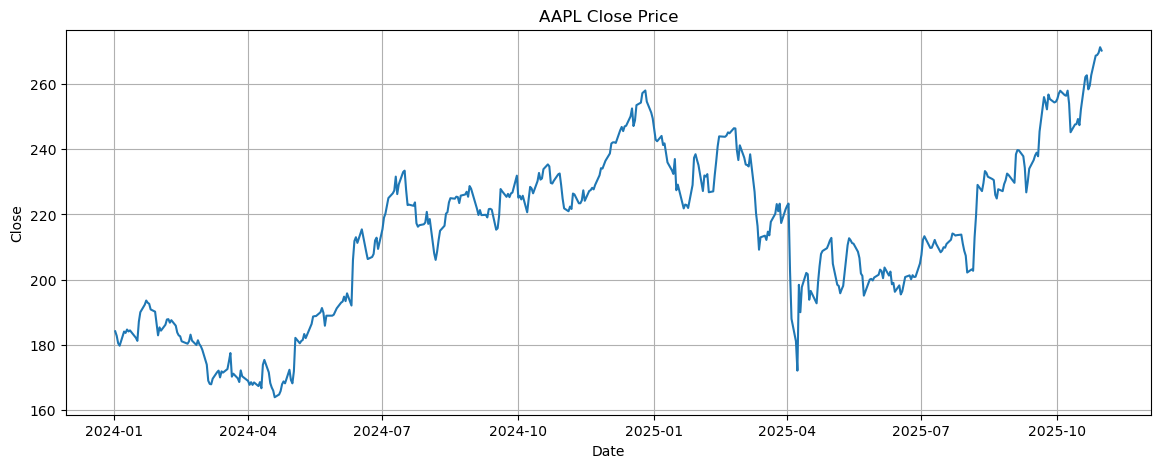

<Figure size 1400x500 with 0 Axes>

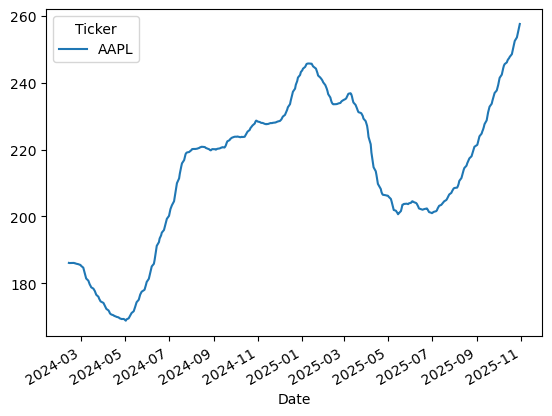

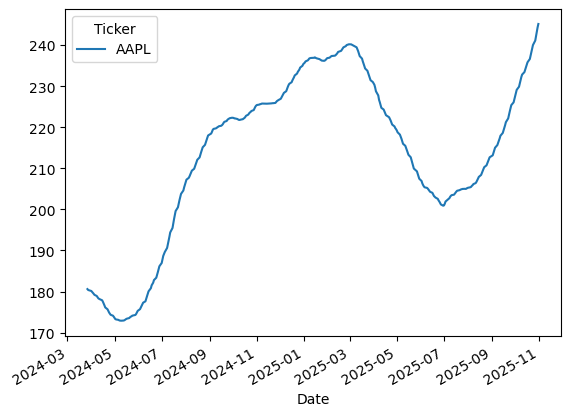

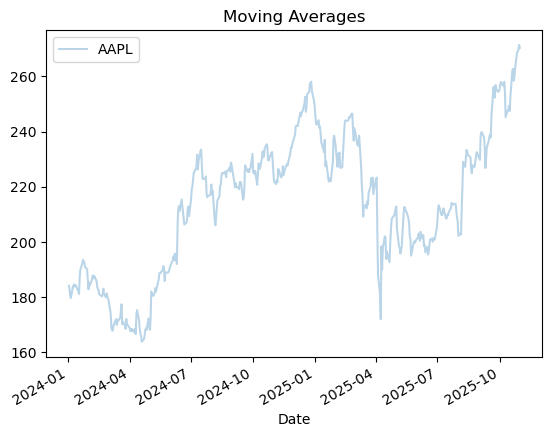

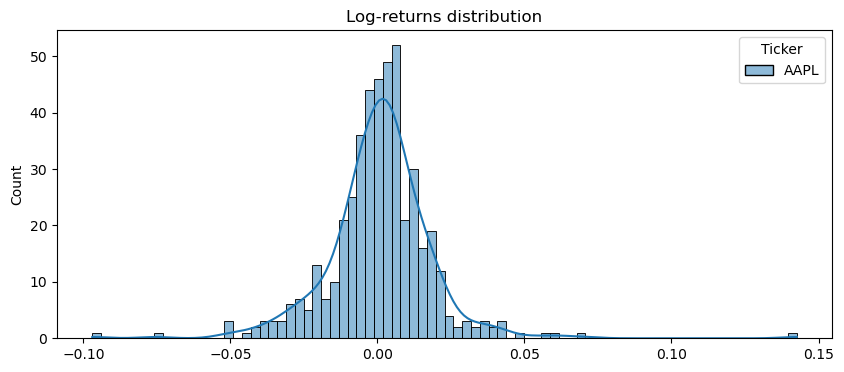

In [4]:
# Summary statistics
print(df.describe())

# Correlation matrix
print(df.corr())

series = df['Close'].copy()

# Simple plot
plt.figure(figsize=(14,5))
plt.plot(series.index, series.values)
plt.title(f"{ticker} Close Price")
plt.xlabel("Date"); plt.ylabel("Close")
plt.grid(True)
plt.show()

# Rolling statistics
plt.figure(figsize=(14,5))
series.rolling(30).mean().plot(label='30d MA')
series.rolling(60).mean().plot(label='60d MA')
series.plot(alpha=0.3, label='Close')
plt.legend(); plt.title("Moving Averages")
plt.show()

# Log returns distribution
returns = np.log(series).diff().dropna()
plt.figure(figsize=(10,4))
sb.histplot(returns, bins=80, kde=True)
plt.title("Log-returns distribution")
plt.show()

                 Close        High         Low        Open    Volume
Date                                                                
2024-01-02  184.081497  186.857993  182.346189  185.578815  82488700
2024-01-03  182.703171  184.319491  181.890048  182.673424  58414500
2024-01-04  180.382828  181.552914  179.361476  180.620803  71983600
2024-01-05  179.658951  181.225688  178.657435  180.462163  62379700
2024-01-08  184.002151  184.041824  179.976239  180.561282  59144500


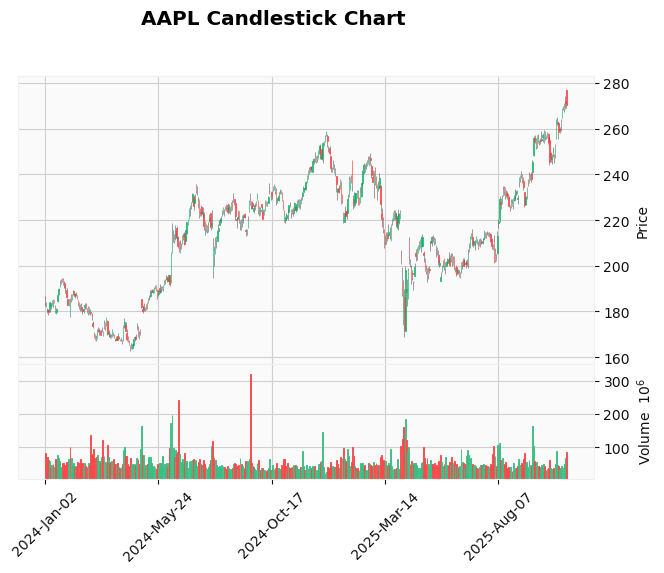

In [5]:
# EXTRA CANDLESTICK CHART
import mplfinance as mpf

df2 = df.copy()

# Flatten multi-level columns
df2.columns = [col[0] for col in df2.columns]

# Ensure Date is datetime index
df2.index = pd.to_datetime(df2.index)

# Sort by date (optional but good practice)
df2 = df2.sort_index()

# Verify final structure
print(df2.head())

mpf.plot(df2, type='candle', volume=True, title='AAPL Candlestick Chart', style='yahoo')

4. Feature Engineering

In [6]:
# Flatten the columns (keep just Price names)
df.columns = [col[0] for col in df.columns]

# Ensure index is datetime
df.index = pd.to_datetime(df.index)

# Sort by date
df = df.sort_index()


In [7]:
# 1. Lag Features
for lag in [1, 2, 3]: # 1-day, 2-day, 3-day
    for col in ['Open','High','Low','Close','Volume']:
        df[f"{col}_lag{lag}"] = df[col].shift(lag)


# 2. Daily returns
df['Return'] = df['Close'].pct_change()

# Log returns (Ln)
df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1))


# 3. Rolling windows
rolling_windows = [3, 7, 14] # 3-day, 7-day, 14-day

for window in rolling_windows:
    # Moving averages
    df[f"MA{window}"] = df['Close'].rolling(window).mean()
    
    # Rolling std (volatility)
    df[f"Volatility{window}"] = df['Close'].rolling(window).std()
    
    # Rolling max/min
    df[f"HighMax{window}"] = df['High'].rolling(window).max()
    df[f"LowMin{window}"] = df['Low'].rolling(window).min()


# 4. Date-based features (0=Monday, 6=Sunday)
df['DayOfWeek'] = df.index.dayofweek

# Month (1-12)
df['Month'] = df.index.month

# Is it end-of-week? (Friday)
df['IsFriday'] = (df.index.dayofweek == 4).astype(int)


# 5. Compute 14-day RSI 
def compute_RSI(series, window=14):
    delta = series.diff()
    
    # Separate gains and losses
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    
    # Compute rolling mean
    avg_gain = gain.rolling(window=window, min_periods=window).mean()
    avg_loss = loss.rolling(window=window, min_periods=window).mean()
    
    # Relative Strength
    RS = avg_gain / avg_loss
    
    # RSI calculation
    RSI = 100 - (100 / (1 + RS))
    
    return RSI

df['RSI14'] = compute_RSI(df['Close'], window=14)

# Regression features
df['Target_Return'] = df['Return'].shift(-1)

# Classification features
df['Target_Trend'] = (df['Close'].shift(-1) > df['Close']).astype(int)

# Drop rows with NaN from lag/rolling/RSI calculations
df = df.dropna()
print(df.columns.tolist())
print(df.shape)

['Close', 'High', 'Low', 'Open', 'Volume', 'Open_lag1', 'High_lag1', 'Low_lag1', 'Close_lag1', 'Volume_lag1', 'Open_lag2', 'High_lag2', 'Low_lag2', 'Close_lag2', 'Volume_lag2', 'Open_lag3', 'High_lag3', 'Low_lag3', 'Close_lag3', 'Volume_lag3', 'Return', 'Log_Return', 'MA3', 'Volatility3', 'HighMax3', 'LowMin3', 'MA7', 'Volatility7', 'HighMax7', 'LowMin7', 'MA14', 'Volatility14', 'HighMax14', 'LowMin14', 'DayOfWeek', 'Month', 'IsFriday', 'RSI14', 'Target_Return', 'Target_Trend']
(446, 40)


5. Time-Based Split

In [8]:
# Time-based split
# Get total number of rows
n = len(df)

# Define 70% train, 30% test
train_size = int(0.7 * n)

# Split chronologically 
train_df = df.iloc[:train_size]
test_df  = df.iloc[train_size:]

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

# Check date ranges
print("Train date range:", train_df.index.min(), "to", train_df.index.max())
print("Test date range:", test_df.index.min(), "to", test_df.index.max())

Train shape: (312, 40)
Test shape: (134, 40)
Train date range: 2024-01-23 00:00:00 to 2025-04-21 00:00:00
Test date range: 2025-04-22 00:00:00 to 2025-10-30 00:00:00


6a. Model - Predict next-day close (regression)

**Why XGBoost is a good choice here:**

*   Handles **non-linearities** (important in trading data).

*   Robust to **feature correlations** (lags, rolling stats).

*   Can handle **missing values** automatically.

*   Fast training on tabular data.

Test RMSE: 0.0189


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


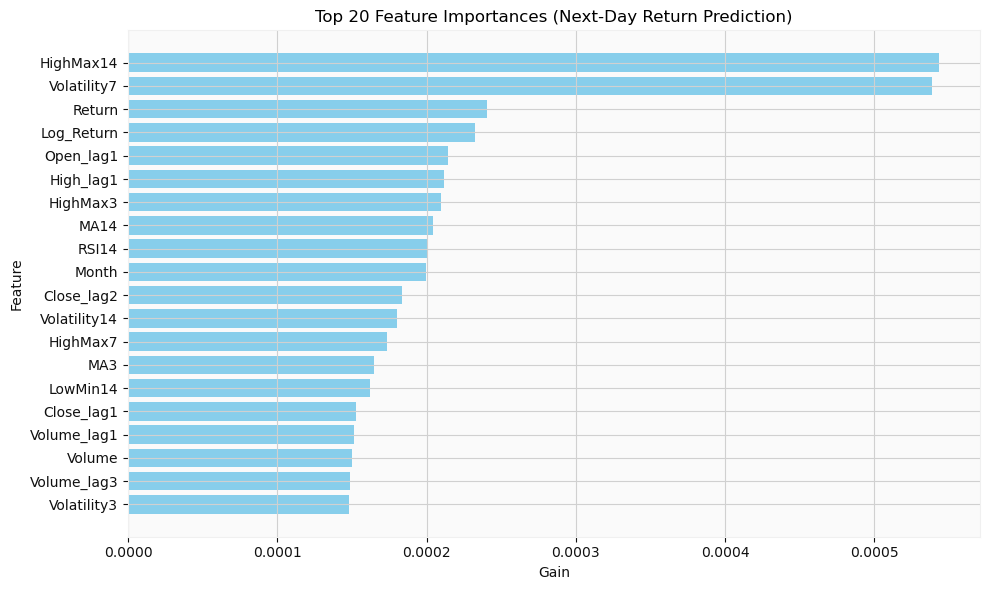

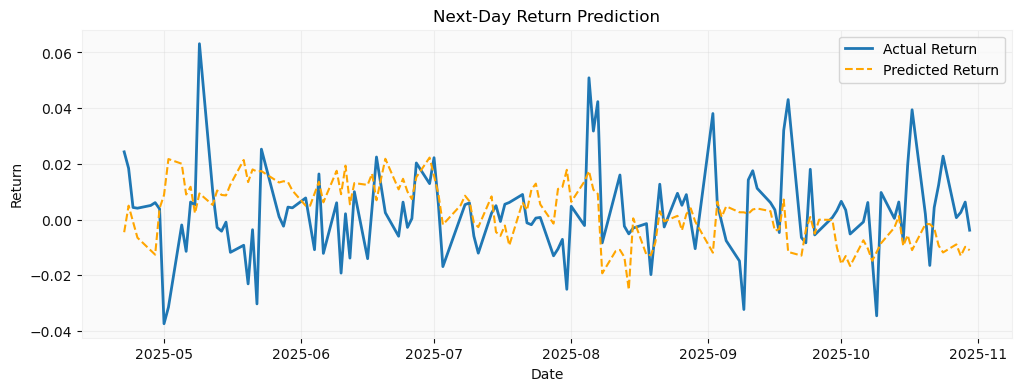

In [9]:
# Define regression features and target
X_train = train_df.drop(columns=['Target_Return','Target_Trend']) 
y_train = train_df['Target_Return']

X_test  = test_df.drop(columns=['Target_Return','Target_Trend'])
y_test  = test_df['Target_Return']

# Define and train the XGBoost model
reg_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Fit the model
reg_model.fit(X_train, y_train, verbose=True)

# Predict on test set
y_pred = reg_model.predict(X_test)

# Evaluate
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Test RMSE: {rmse:.4f}")

# Extract feature importance values
importance = reg_model.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Gain': list(importance.values())
}).sort_values(by='Gain', ascending=False).head(20)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Gain'], color='skyblue')
plt.xlabel('Gain')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances (Next-Day Return Prediction)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

pred_df = pd.DataFrame({
    'Actual_Return': y_test,
    'Predicted_Return': y_pred
}, index=y_test.index)

plt.figure(figsize=(12, 4))
plt.plot(pred_df.index, pred_df['Actual_Return'], label='Actual Return', linewidth=2)
plt.plot(pred_df.index, pred_df['Predicted_Return'], label='Predicted Return', linestyle='--', color='orange')
plt.title('Next-Day Return Prediction')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


6b. Model - Predict next-day trend (classification)

Accuracy: 0.4627
              precision    recall  f1-score   support

           0       0.33      0.24      0.28        58
           1       0.52      0.63      0.57        76

    accuracy                           0.46       134
   macro avg       0.43      0.44      0.43       134
weighted avg       0.44      0.46      0.45       134



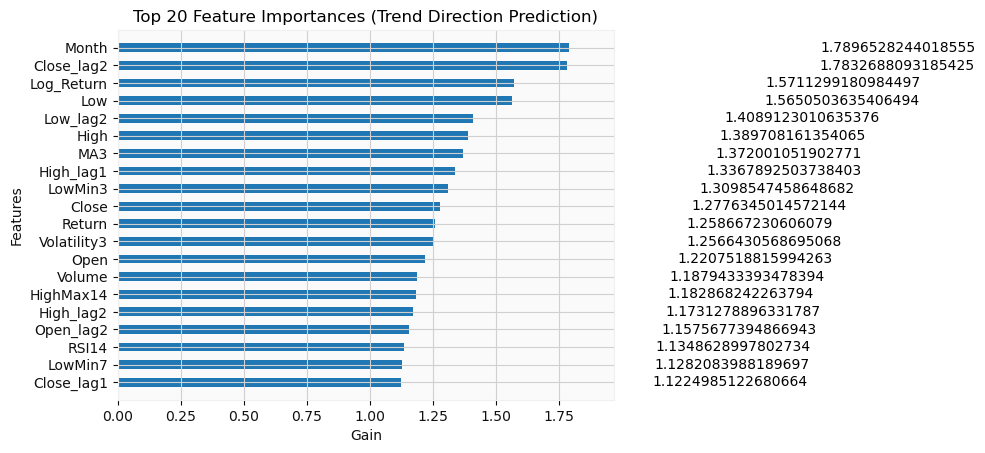

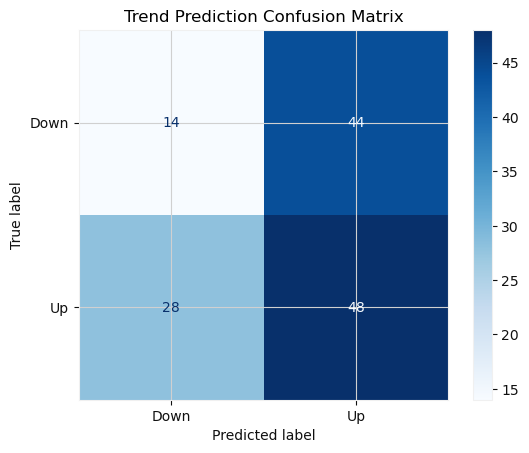

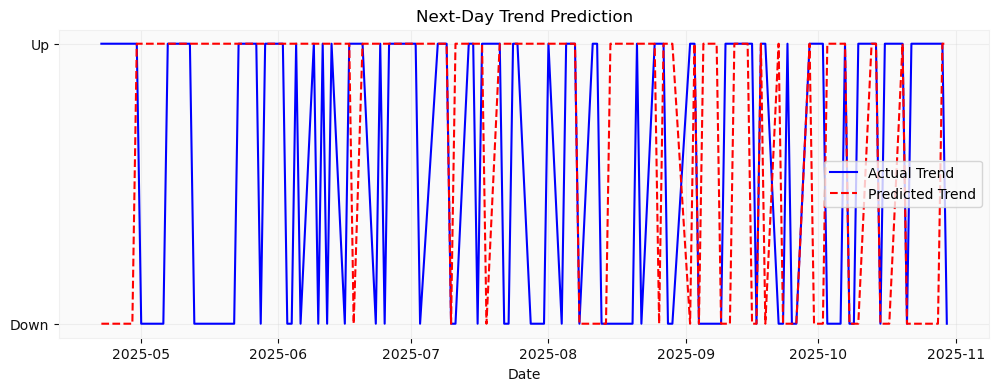

In [10]:
# Define classification features and target
X_train = train_df.drop(columns=['Target_Trend','Target_Return']) 
y_train = train_df['Target_Trend']

X_test  = test_df.drop(columns=['Target_Trend','Target_Return'])
y_test  = test_df['Target_Trend']

# Define and train the XGBoost model
clf_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Fit the model
clf_model.fit(X_train, y_train, verbose=True)

# Evaluate
y_pred_class = clf_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_class):.4f}")
print(classification_report(y_test, y_pred_class))

# Plot feature importance
xgb.plot_importance(clf_model, 
                    importance_type='gain', # gain, weight, cover
                    max_num_features=20,
                    height=0.5,
                    title='Top 20 Feature Importances (Trend Direction Prediction)',
                    xlabel='Gain')

plt.show()

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Down', 'Up'])
disp.plot(cmap='Blues')
plt.title('Trend Prediction Confusion Matrix')
plt.show()

trend_df = pd.DataFrame({
    'Actual Trend': y_test.replace({0: 'Down', 1: 'Up'}),
    'Predicted Trend': y_pred_class
}, index=y_test.index)

plt.figure(figsize=(12, 4))
plt.plot(trend_df.index, y_test, label='Actual Trend', color='blue')
plt.plot(trend_df.index, y_pred_class, label='Predicted Trend', color='red', linestyle='--')
plt.yticks([0, 1], ['Down', 'Up'])
plt.title('Next-Day Trend Prediction')
plt.xlabel('Date')
plt.legend()
plt.grid(alpha=0.3)
plt.show()